In [2]:
#Create time: 2022-8-8 For an analysis of paper 
#     “Wheat Germplasm Adaptation to Warmer Climate”
#The purpuse of the script is to investige which lines can adapt to warmer climate and to what warming extent.

#Step 1: Papare yield and phenology, with both observed and simulated filled values (phenology) u, Gi, Ej, GixEj
  #input: Final_SimFilledSow_ESWYT.csv
#Step 2: Papare weather variables for all entries
  #input: weather.csv
#Step 3: Regression between yield variations and climate (growing-season mean and GDD
                   #Y=u+Gi+Ej+aiCLIij+biCLIij+e
    #Three fitting approches are used to estimate ai and bi - 1) LASSO, 2) random forest, 3) support vector regression
    #CLI: tavg, tdr, gdd30, rs, p, vpd, ws, co2
    #Three growing durations: sowing-heading-300gdd, -300gdd~heading~+100gdd, heading+100gdd-maturity
    #yld variation = ai*(7cli*3period)^2 + bi*(7cli*3period)+ci*co2+e without and with CO2 being included in the model
    #total number of predictor variables: 42 (without co2), 43 (with co2)
  #output: parameters: la_noco2.csv, la_co2.csv, rf_noco2.csv, rf_co2.csv, sv_noco2.csv, sv_co2.csv
  #Comparison among different fitting methods and their capacity to reproduce past yield
  #Select a best fitting approach. 
#Step 4: Simulate phenology for all lines across all environments with crop model
#Step 5: Estimated yield-climate responses for all lines across all environments
#Step 6: lines exhibit different yield response to past climate change average across all locations, and locations
#        exhibit different adapation ability across all genotypes
#Step 7: Steps 4-7 applied to future climate change scenarios, without and with CO2 effects included in the model 

In [1]:
import pandas as pd
import numpy as np
#import datetime as dt
import os
#from collections import Counter
import seaborn as sns
import math
import glob
from datetime import timedelta
from scipy.stats import linregress
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
#import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
#Define variable and specify directories
nursery=['ESWYT','IDYN','IWWYT_IRR','HTWYT','SAWYT','IWWYT_SA']
simphedir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\0.1_CropModelDataFill\\3_Results\\Output_CSV\\Calibration\\"
hisweadir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Weather\\ARC5_2021\\" #ARC5
futweadir="H:\\CMIP6\FromCarlo\\" #Future climate scenarios for each GCM and site
outdir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\0_Adaptation\\3_Results\\"
figdir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\0_Adaptation\\6_Plots\\"

In [3]:
#All functions
from scipy.stats import pearsonr
def MyPersonCorr(x,y):
    temp=pd.DataFrame()
    temp['x']=x
    temp['y']=y
    temp=temp.dropna()
    return pearsonr(temp['x'],temp['y'])

# Step 1 Prepare Yield and Phenology

In [ ]:
weat_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Weather\\ARC5_2021\\" 
def cloest_wea(wea):
    temp=wea.split('_')
    lat=temp[0].astype('float')
    lon=substr(temp[1],1,len(temp[1])-4)
    filel=[os.path.splitext(os.path.basename(x))[0] for x in glob.glob(weat_dir+"*.csv")]
    filel=pd.DataFrame([x.split('_') for x in filel])
    filel['la']=filel.iloc[:,0].astype('float')
    filel['lo']=filel.iloc[:,1].astype('float')
    filel['dis']=((filel['la']-lat)**2+(filel['lo']-lon)**2)**(1/2)
    min_value=filel['dis'].min()
    #min_index=np.argmin(wea['dis'])
    min_index=filel['dis'].idxmin(axis=0,skipna=True)
    if min_value<50:
        return filel.iloc[min_index,0]+"_"+filel.iloc[min_index,1]
    else:
        return ""
    
def climate(wea,year,sow,head,mat):
    if os.path.isfile(weat_dir+wea):
        wea=wea
    else:
        wea=cloest_wea(wea)
    value=np.nan * np.ones(shape=(len(year),21))
    if not np.isnan(wea):
        df_we=pd.read_csv(weat_dir+wea)
        df.columns=['date','rs','tmax','tmin','p','rh','vpd','ws']
        df['tavg']=(df.tmax+df.tmin)/2
        df['tdr']=df.tmax-df.tmin
        df['gdd']=[x-30 if x-30>0 else 0 for x in df.tavg]
        for i in range(len(year)):
            sowi=datetime.datetime.strptime(str(int(year))+'-01-01','%Y-%m-%d')+timedelta(sow[i])
            headi=sowi+timedelta(head[i])
            mathi=sowi+timedelta(matu[i])
            sowi=int(sowi.strftime('%Y%m%d'))
            headi=int(headi.strftime('%Y%m%d'))
            matui=int(matui.strftime('%Y%m%d'))
            #find head-300, head+100
            head_index=df.loc[df.date==headi,].index
            gdd=0
            while(gdd<=300):
                head_index=head_index-1
                gdd=gdd+max(df.loc[head_index,'tavg'],0)
            head_b300=df.date[head_index]
            head_index=df.loc[df.date==headi,].index
            gdd=0
            while(gdd<=100):
                head_index=head_index+1
                gdd=gdd+max(df.loc[head_index,'tavg'],0)
            head_a100=df.date[head_index]
            temp=df.loc[(df.date>=sowi) & (df.date<=head_b300)]
            value[i,:7]=[round(temp.tavg.mean(),1),round(temp.tdr.mean(),1),round(temp.gdd.sum(),1),
                        round(temp.rs.mean(),1),round(temp.p.mean(),1),round(temp.vpd.mean(),1),round(temp.ws.mean(),1)]
            temp=df.loc[(df.date>=head_b300) & (df.date<=head_a100)]
            value[i,7:14]=[round(temp.tavg.mean(),1),round(temp.tdr.mean(),1),round(temp.gdd.sum(),1),
                        round(temp.rs.mean(),1),round(temp.p.mean(),1),round(temp.vpd.mean(),1),round(temp.ws.mean(),1)]
            temp=df.loc[(df.date>=head_a100) & (df.date<=matu)]
            value[i,14:]=[round(temp.tavg.mean(),1),round(temp.tdr.mean(),1),round(temp.gdd.sum(),1),
                        round(temp.rs.mean(),1),round(temp.p.mean(),1),round(temp.vpd.mean(),1),round(temp.ws.mean(),1)]
    return value

In [ ]:
#Generate the nursery data including all climatic variables for fitting, removed outliers values by quantile 99
#Need remove sites IBWSN: 27101 Remove sites with outlier yld
#n=2 #nursery
for n in range(6):
    #Step 1 - Yield and Phenology
    trial=pd.read_csv(simphedir+nursery[n]+"\\Final_SimFilledSow__"+nursery[n]+".csv")
    #IBWSN 27101 yield unit is g/m, need to devide by 100 to convert to t/ha 27101-1996, 20306-2006
    ###########################Remove sites that have outlier yield#################################
    ################################################################################################
    Ej_y=trial[['loc','year','yld']].groupby(['loc','year']).mean().reset_index()
    Ej=Ej_y[['loc','year']].groupby('loc').count().reset_index()
    quantile99=Ej_y[['loc','yld']].groupby('loc').quantile(0.99).reset_index()
    Ej=Ej.merge(quantile99,how='left')
    Ej.columns=['loc','season','quantile99']
    Ej_y=Ej_y.merge(Ej,how='left')
    Ej_y=Ej_y.sort_values(by='yld',ascending=False).reset_index()
    outliers=[]
    for x in Ej_y.index:
        if (Ej_y.season[x]==1) & (Ej_y.yld[x]>20):
            outliers=outliers+[1]
        elif (Ej_y.season[x]>1) & (Ej_y.yld[x]>=Ej_y.quantile99[x]) & (Ej_y.yld[x]>20):
            outliers=outliers+[1]
        else:
            outliers=outliers+[0]  
    Ej_y['outliers']=outliers
    #Ej_y.sort_values(by='yld',ascending=False).iloc[:60,]
    Ej_y=Ej_y[Ej_y.outliers==0][['loc','year']]
    ################################################################################################
    ################################################################################################
    trial=trial.merge(Ej_y,how='inner')

    trial['id']=trial.index
    trial['gen']=[x.split('@')[1] for x in trial.sid_gen]
    trial=trial[['id','gen','loc','wea_file','year','yearofsow','dayofsow','dayofhar','yld','head','anth','matu','sim_head','sim_anth','sim_matu']]
    Yld=trial[['id','gen','loc','yld']]
    Gi=Yld[['gen','yld']].groupby('gen').mean().reset_index()
    Gi['Gi']=Gi.yld-Gi.yld.mean()
    Yld=Yld.merge(Gi[['gen','Gi']],how='left')
    Ej=Yld[['loc','yld']].groupby('loc').mean().reset_index()
    Ej['Ej']=Ej.yld-Ej.yld.mean()
    Yld=Yld.merge(Ej[['loc','Ej']],how='left')
    Yld['delYld']=Yld['yld']-Yld['Gi']-Yld['Ej']-Yld.yld.mean()

    #Step 2 - Combining weather variables
    co2=pd.read_csv("E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Weather\\CO2_concentration_his.csv")
    Weat=pd.DataFrame(columns=['id','year','yearofsow','sow','head','matu']+[x+'_'+y for y in ['veg','rep','gfi'] for x in ['tavg','tdr','gdd30','rs','p','rh','vpd','ws']])
    for wea in trial.wea_file.unique():
        df=trial.loc[trial.wea_file==wea,['id','year','yearofsow','dayofsow','dayofhar','head','anth','matu','sim_head','sim_anth','sim_matu']]
        df=df.merge(co2,on='year',how='left')
        year=df[['year','yearofsow']].min(axis=1).tolist()
        sow=[x-(x//365)*365 for x in df.dayofsow]
        sow=[1 if x==0 else x for x in sow]
        head=[]
        matu=[]
        for x in df.index:
            aa=[df.loc[x,'head']/df.loc[x,'sim_head'],df.loc[x,'anth']/df.loc[x,'sim_anth'],df.loc[x,'matu']/df.loc[x,'sim_matu']]
            bb=[abs(t-1) for t in aa]
            ratio=aa[pd.Series(bb).idxmin()]
            if np.isnan(ratio):ratio=1
            if not np.isnan(df.loc[x,'head']):
                head=head+[round(df.loc[x,'head'])]
            else:
                head=head+[round(df.loc[x,'sim_head']*ratio)]
            if not np.isnan(df.loc[x,'matu']):
                matu=matu+[round(df.loc[x,'matu'])]
            else:
                matu=matu+[round(df.loc[x,'sim_matu']*ratio)]
        out=pd.DataFrame(climate(wea,year,sow,head,matu))
        out.columns=[x+'_'+str(y) for y in ['veg','rep','gfi'] for x in ['tavg','tdr','gdd30','rs','p','rh','vpd','ws']]
        out['id']=df.id.tolist()
        out['co2']=df['co2']
        out['year']=df['year']
        out['yearofsow']=df['yearofsow']
        out['sow']=sow
        out['head']=head
        out['matu']=matu
        Weat=pd.concat([Weat,out],ignore_index=True)
        #Weat.append(out)
    Weat=Weat.sort_values(by=['id'])

    #Step 3 - Run regression - test, determine models
    trial=Yld.merge(Weat,on='id')
    #Step 4 - Run predictions across lines and sites
    trial.to_csv(outdir+nursery[n]+"_Obs_Sim_Yld_Phe_Climate.csv",index=False) 
Yld=[]
Weat=[]  

In [ ]:
#Generate the nursery data including all climatic variables for fitting, keep all entries, keep outliers
#Only consider climate
for n in range(6):
    #Step 1 - Yield and Phenology
    trial=pd.read_csv(simphedir+nursery[n]+"\\Final_SimFilledSow__"+nursery[n]+".csv")
    trial['id']=trial.index
    trial['gen']=[x.split('@')[1] for x in trial.sid_gen]
    trial=trial[['id','gen','loc','wea_file','year','yearofsow','dayofsow','dayofhar','yld','head','anth','matu','sim_head','sim_anth','sim_matu']]
    
    #Step 2 - Combining weather variables
    co2=pd.read_csv("E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\Weather\\CO2_concentration_his.csv")
    Weat=pd.DataFrame(columns=['id','gen','loc','year','sow','head','matu']+[x+'_'+y for y in ['veg','rep','gfi'] for x in ['tavg','tdr','gdd30','rs','p','rh','vpd','ws']])
    for wea in trial.wea_file.unique():
        df=trial.loc[trial.wea_file==wea,['id','gen','loc','yld','year','yearofsow','dayofsow','dayofhar','head','anth','matu','sim_head','sim_anth','sim_matu']]
        df=df.merge(co2,on='year',how='left')
        year=df[['year','yearofsow']].min(axis=1).tolist()
        sow=[x-(x//365)*365 for x in df.dayofsow]
        sow=[1 if x==0 else x for x in sow]
        head=[]
        matu=[]
        for x in df.index:
            aa=[df.loc[x,'head']/df.loc[x,'sim_head'],df.loc[x,'anth']/df.loc[x,'sim_anth'],df.loc[x,'matu']/df.loc[x,'sim_matu']]
            bb=[abs(t-1) for t in aa]
            ratio=aa[pd.Series(bb).idxmin()]
            if np.isnan(ratio):ratio=1
            if not np.isnan(df.loc[x,'head']):
                head=head+[round(df.loc[x,'head'])]
            else:
                head=head+[round(df.loc[x,'sim_head']*ratio)]
            if not np.isnan(df.loc[x,'matu']):
                matu=matu+[round(df.loc[x,'matu'])]
            else:
                matu=matu+[round(df.loc[x,'sim_matu']*ratio)]
        out=pd.DataFrame(climate(wea,year,sow,head,matu))
        out.columns=[x+'_'+str(y) for y in ['veg','rep','gfi'] for x in ['tavg','tdr','gdd30','rs','p','rh','vpd','ws']]
        out['id']=df.id.tolist()
        out['co2']=df['co2']
        out['gen']=df['gen']
        out['loc']=df['loc']
        out['yld']=df['yld']
        out['year']=year
        out['sow']=sow
        out['head']=head
        out['matu']=matu
        Weat=pd.concat([Weat,out],ignore_index=True)
        #Weat.append(out)
    Weat=Weat.sort_values(by=['id'])
    #Step 3 - Run regression - test, determine models
    #Step 4 - Run predictions across lines and sites
    Weat.to_csv(outdir+nursery[n]+"_Obs_Sim_Yld_Phe_Climate_All.csv",index=False)
trial=[]
Weat=[]

# Step 2 - Test Model and Fitting Approach

# Random Forest - quardric 32 

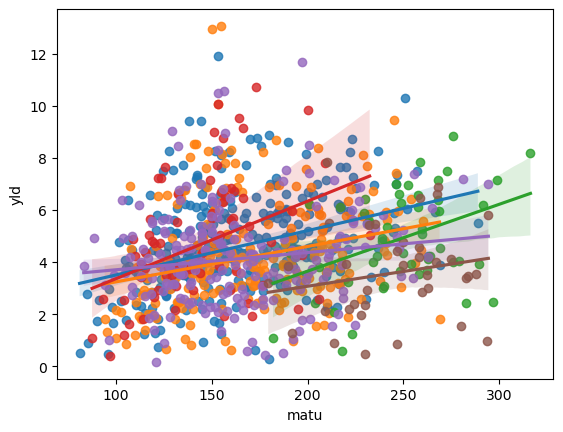

In [17]:
#model=DecisionTreeRegressor()
train=pd.DataFrame(columns=['obs','sim'])
test=pd.DataFrame(columns=['obs','sim'])
for n in range(6):
    trial=pd.read_csv(simphedir+nursery[n]+"\\Final_SimFilledSow__"+nursery[n]+".csv")
    trial['id']=trial.index
    trial['gen']=[x.split('@')[1] for x in trial.sid_gen]
    trial=trial[['id','gen','loc','wea_file','year','yearofsow','dayofsow','dayofhar','yld','head','anth','matu','sim_head','sim_anth','sim_matu']]
    matu=trial[['loc','matu']].groupby('loc').mean().dropna().reset_index()
    
    trial=pd.read_csv(outdir+nursery[n]+"_Obs_Sim_Yld_Phe_Climate.csv")
    Ej=trial[['loc','yld']].groupby('loc').mean().dropna().reset_index()
    Ej=Ej.merge(matu,on='loc',how='left')
    p=sns.regplot(x='matu',y='yld',data=Ej,robust=True)
    Ej_matu_reg=linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    #y=Ej_matu_reg[1]+Ej_matu_reg[0]x
    E_fit=Ej_matu_reg[1]+Ej_matu_reg[0]*Ej['matu']
    Ej['Ej']=Ej['yld']-E_fit-E_fit.mean()  #Ej is the site caused variation can not be explained by climate
    
    trial.drop('Ej', inplace=True, axis=1)
    trial=trial.merge(Ej[['loc','Ej']],on='loc',how='left')
    grand_mean=trial.yld.mean()
    trial['delYld1']=trial['yld']-grand_mean-trial['Gi']-trial['Ej']
    
    cli=[x+'_'+y for y in ['veg','rep','gfi'] for x in ['tavg','tdr','gdd30','rs','p','rh','vpd','ws']]
    cli_all=sum([[x+'_sqr',x] for x in cli],[])#+['co2']
    
    for g in trial.gen.unique():
        Yld=trial[trial.gen==g].iloc[:,3:][['delYld1','yld','Gi','Ej']+cli+['co2']].dropna()
        if Yld.shape[0]>=30: #make sure there are at least 10 sites
            for c in cli: Yld[c+'_sqr']=Yld[c]**2
            y=Yld['delYld1']
            X=Yld[['yld','Gi','Ej']+cli_all]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=31)
            rf=RandomForestRegressor(n_estimators=1000,random_state=42) #alpha=0.1,max_iter=10e6
            rf.fit(X_train.loc[:,cli_all],y_train)
            temp=pd.DataFrame(columns=['obs','sim'])
            temp.obs=X_train.yld
            temp.sim=rf.predict(X_train.loc[:,cli_all])+X_train.loc[:,'Gi']+grand_mean+X_train.loc[:,'Ej']
            #Yld_train=Yld_train.append(temp)
            train=pd.concat([train,temp],ignore_index=True)
            temp=pd.DataFrame(columns=['obs','sim'])
            temp.obs=X_test.yld
            temp.sim=rf.predict(X_test.loc[:,cli_all])+X_test.loc[:,'Gi']+grand_mean+X_test.loc[:,'Ej']
            #Yld_test=Yld_test.append(temp)
            test=pd.concat([test,temp],ignore_index=True)

#fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
#sns.regplot(train.obs,train.sim,ax=ax[0])
#r2=round(np.corrcoef(train.obs,train.sim)[0,1]**2,3)
#ax[0].text(3,3,'R$^2$='+str(r2),fontsize=12)
#test=test[(test.sim>0)&(test.sim<20)]
#sns.regplot(test.obs,test.sim,ax=ax[1])
#r2=round(np.corrcoef(test.obs,test.sim)[0,1]**2,3)
#ax[1].text(3,3,'R$^2$='+str(r2),fontsize=12)

In [8]:
#Plot RF method - comparison between obseration and simuluation 
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

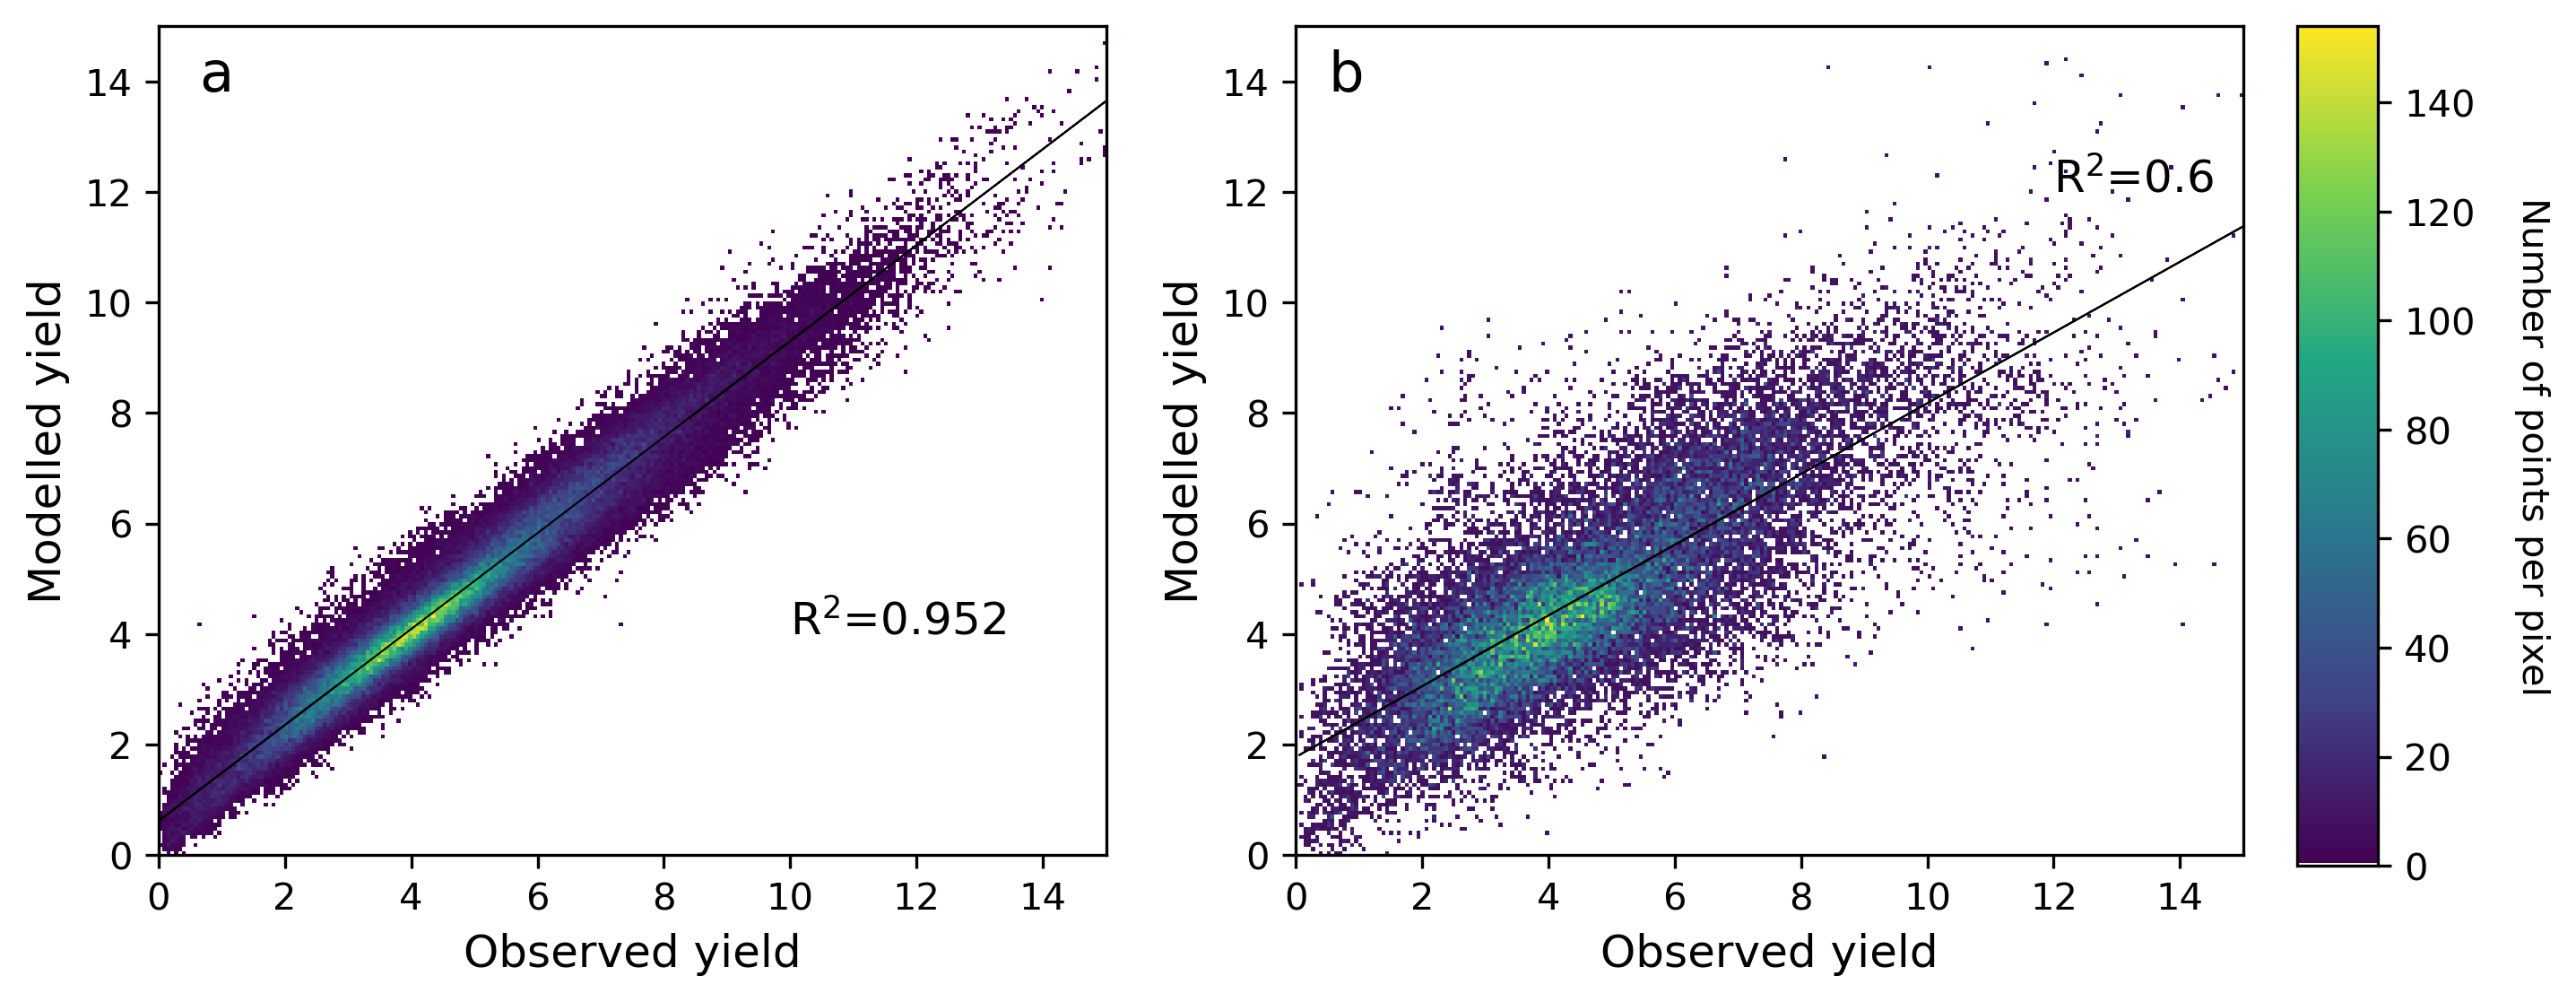

In [32]:
fig=plt.figure(figsize=(10,4),dpi=300)
ax = fig.add_subplot(1,2,1,projection='scatter_density')

#Train
x=train.obs
y=train.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
density=ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(10,4,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
#Test
ax = plt.subplot(1,2,2,projection='scatter_density')
x=test.obs
y=test.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(12,12,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
cax=fig.add_axes([0.92,0.1,0.03,0.78])
cb=fig.colorbar(density,cax=cax)

cb.set_label('Number of points per pixel',rotation=270,labelpad=20)
plt.gcf().text(0.14,0.82,'A',fontsize=15)
plt.gcf().text(0.56,0.82,'B',fontsize=15)
plt.show()

In [19]:
#from scipy.stats import gaussian_kde

(26265, 2)

# Random Forest - linear 16

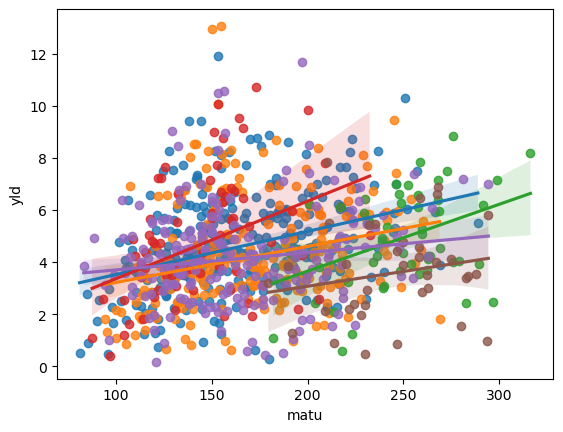

In [5]:
#model=DecisionTreeRegressor()
cli=[x+'_'+y for y in ['veg','rep','gfi'] for x in ['tavg','tdr','gdd30','rs','p','rh','vpd','ws']]
cli_all=sum([[x+'_sqr',x] for x in cli],[])#+['co2']
train=pd.DataFrame(columns=['obs','sim'])
test=pd.DataFrame(columns=['obs','sim'])
for n in range(6):
    trial=pd.read_csv(simphedir+nursery[n]+"\\Final_SimFilledSow__"+nursery[n]+".csv")
    trial['id']=trial.index
    trial['gen']=[x.split('@')[1] for x in trial.sid_gen]
    trial=trial[['id','gen','loc','wea_file','year','yearofsow','dayofsow','dayofhar','yld','head','anth','matu','sim_head','sim_anth','sim_matu']]
    matu=trial[['loc','matu']].groupby('loc').mean().dropna().reset_index()
    
    trial=pd.read_csv(outdir+nursery[n]+"_Obs_Sim_Yld_Phe_Climate.csv")
    Ej=trial[['loc','yld']+cli].groupby('loc').mean().dropna().reset_index()
    #for c in cli: E[c+'_sqr']=E[c]**2
    #y=E['yld']
    #X=E[cli]  #cli_all
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=31)
    #lasso=Lasso(alpha=al,max_iter=1000000)
    #rf=RandomForestRegressor(n_estimators=1000,random_state=42) #alpha=0.1,max_iter=10e6
    #rf.fit(X,y)
    #E['cliyld']=rf.predict(X)
    #E['Ej_c']=E.cliyld-E.cliyld.mean()
    #E['Ej']=E.yld-E.yld.mean()
    #E['Ej_noc']=E.Ej-E.Ej_c
    #Ej=E[['loc','Ej_noc']]
    Ej=Ej.merge(matu,on='loc',how='left')
    p=sns.regplot(x='matu',y='yld',data=Ej,robust=True)
    Ej_matu_reg=linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    #y=Ej_matu_reg[1]+Ej_matu_reg[0]*x
    E_fit=Ej_matu_reg[1]+Ej_matu_reg[0]*Ej['matu']
    Ej['Ej']=Ej['yld']-E_fit-E_fit.mean()  #Ej is the site caused variation can not be explained by climate
    
    trial.drop('Ej', inplace=True, axis=1)
    trial=trial.merge(Ej[['loc','Ej']],on='loc',how='left')
    grand_mean=trial.yld.mean()
    trial['delYld1']=trial['yld']-grand_mean-trial['Gi']-trial['Ej']
    
    for g in trial.gen.unique():
        Yld=trial[trial.gen==g].iloc[:,3:][['delYld1','yld','Gi','Ej']+cli+['co2']].dropna()
        if Yld.shape[0]>=30: #make sure there are at least 10 sites
            #for c in cli: Yld[c+'_sqr']=Yld[c]**2
            y=Yld['delYld1']
            X=Yld[['yld','Gi','Ej']+cli]  #cli_all
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=31)
            rf=RandomForestRegressor(n_estimators=1000,random_state=42) #alpha=0.1,max_iter=10e6
            rf.fit(X_train.loc[:,cli],y_train)
            temp=pd.DataFrame(columns=['obs','sim'])
            temp.obs=X_train.yld
            temp.sim=rf.predict(X_train.loc[:,cli])+X_train.loc[:,'Gi']+grand_mean+X_train.loc[:,'Ej']
            #Yld_train=Yld_train.append(temp)
            train=pd.concat([train,temp],ignore_index=True)
            temp=pd.DataFrame(columns=['obs','sim'])
            temp.obs=X_test.yld
            temp.sim=rf.predict(X_test.loc[:,cli])+X_test.loc[:,'Gi']+grand_mean+X_test.loc[:,'Ej']
            #Yld_test=Yld_test.append(temp)
            test=pd.concat([test,temp],ignore_index=True)

In [ ]:
fig=plt.figure(figsize=(10,4),dpi=300)
ax = fig.add_subplot(1,2,1,projection='scatter_densi

#Train
x=train.obs
y=train.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
density=ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(10,4,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
#Test
ax = plt.subplot(1,2,2,projection='scatter_density')
x=test.obs
y=test.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(12,12,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
cax=fig.add_axes([0.92,0.1,0.03,0.78])
cb=fig.colorbar(density,cax=cax)

cb.set_label('Number of points per pixel',rotation=270,labelpad=20)
plt.gcf().text(0.14,0.82,'a',fontsize=15)
plt.gcf().text(0.56,0.82,'b',fontsize=15)
plt.show

In [ ]:
#model=DecisionTreeRegressor()
al=0.1
train=pd.DataFrame(columns=['obs','sim'])
test=pd.DataFrame(columns=['obs','sim'])
for n in range(6):
    trial=pd.read_csv(simphedir+nursery[n]+"\\Final_SimFilledSow__"+nursery[n]+".csv")
    trial['id']=trial.index
    trial['gen']=[x.split('@')[1] for x in trial.sid_gen]
    trial=trial[['id','gen','loc','wea_file','year','yearofsow','dayofsow','dayofhar','yld','head','anth','matu','sim_head','sim_anth','sim_matu']]
    matu=trial[['loc','matu']].groupby('loc').mean().dropna().reset_index()
    
    trial=pd.read_csv(outdir+nursery[n]+"_Obs_Sim_Yld_Phe_Climate.csv")
    Ej=trial[['loc','yld']].groupby('loc').mean().dropna().reset_index()
    Ej=Ej.merge(matu,on='loc',how='left')
    #p=sns.regplot(x='matu',y='yld',data=Ej,robust=True)
    Ej_matu_reg=linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    #y=Ej_matu_reg[1]+Ej_matu_reg[0]x
    E_fit=Ej_matu_reg[1]+Ej_matu_reg[0]*Ej['matu']
    Ej['Ej']=Ej['yld']-E_fit-E_fit.mean()  #Ej is the site caused variation can not be explained by climate
    
    trial.drop('Ej', inplace=True, axis=1)
    trial=trial.merge(Ej[['loc','Ej']],on='loc',how='left')
    grand_mean=trial.yld.mean()
    trial['delYld1']=trial['yld']-grand_mean-trial['Gi']-trial['Ej']
    
    cli=[x+'_'+y for y in ['veg','rep','gfi'] for x in ['tavg','tdr','gdd30','rs','p','rh','vpd','ws']]
    cli_all=sum([[x+'_sqr',x] for x in cli],[])#+['co2']
    
    for g in trial.gen.unique():
        Yld=trial[trial.gen==g].iloc[:,3:][['delYld1','yld','Gi','Ej']+cli+['co2']].dropna()
        if Yld.shape[0]>=30: #make sure there are at least 10 sites
            #for c in cli: Yld[c+'_sqr']=Yld[c]**2
            y=Yld['delYld1']
            X=Yld[['yld','Gi','Ej']+cli]  #cli_all
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=31)
            rf=RandomForestRegressor(n_estimators=1000,random_state=42) #alpha=0.1,max_iter=10e6
            rf.fit(X_train.loc[:,cli],y_train)
            temp=pd.DataFrame(columns=['obs','sim'])
            temp.obs=X_train.yld
            temp.sim=rf.predict(X_train.loc[:,cli])+X_train.loc[:,'Gi']+grand_mean+X_train.loc[:,'Ej']
            #Yld_train=Yld_train.append(temp)
            train=pd.concat([train,temp],ignore_index=True)
            temp=pd.DataFrame(columns=['obs','sim'])
            temp.obs=X_test.yld
            temp.sim=rf.predict(X_test.loc[:,cli])+X_test.loc[:,'Gi']+grand_mean+X_test.loc[:,'Ej']
            #Yld_test=Yld_test.append(temp)
            test=pd.concat([test,temp],ignore_index=True)
fig=plt.figure(figsize=(10,4),dpi=300)
ax = fig.add_subplot(1,2,1,projection='scatter_density')

#Train
x=train.obs
y=train.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
density=ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(10,4,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
#Test
ax = plt.subplot(1,2,2,projection='scatter_density')
x=test.obs
y=test.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(12,12,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
cax=fig.add_axes([0.92,0.1,0.03,0.78])
cb=fig.colorbar(density,cax=cax)

cb.set_label('Number of points per pixel',rotation=270,labelpad=20)
plt.gcf().text(0.14,0.82,'a',fontsize=15)
plt.gcf().text(0.56,0.82,'b',fontsize=15)
plt.show()

In [52]:
n=0
trial=pd.read_csv(outdir+nursery[n]+"_Obs_Sim_Yld_Phe_Climate.csv")
#Ej=trial[['loc','yld']].groupby('loc').mean().dropna().reset_index()
#Ej=Ej.merge(matu,on='loc',how='left')
#p=sns.regplot(x='matu',y='yld',data=Ej,robust=True)
#Ej_matu_reg=linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
#y=Ej_matu_reg[1]+Ej_matu_reg[0]x
#E_fit=Ej_matu_reg[1]+Ej_matu_reg[0]*Ej['matu']
#Ej['Ej']=Ej['yld']-E_fit-E_fit.mean()  #Ej is the site caused variation can not be exp


D:\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
D:\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+02, tolerance: 9.822e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
D:\anaconda3\Lib\site-pac

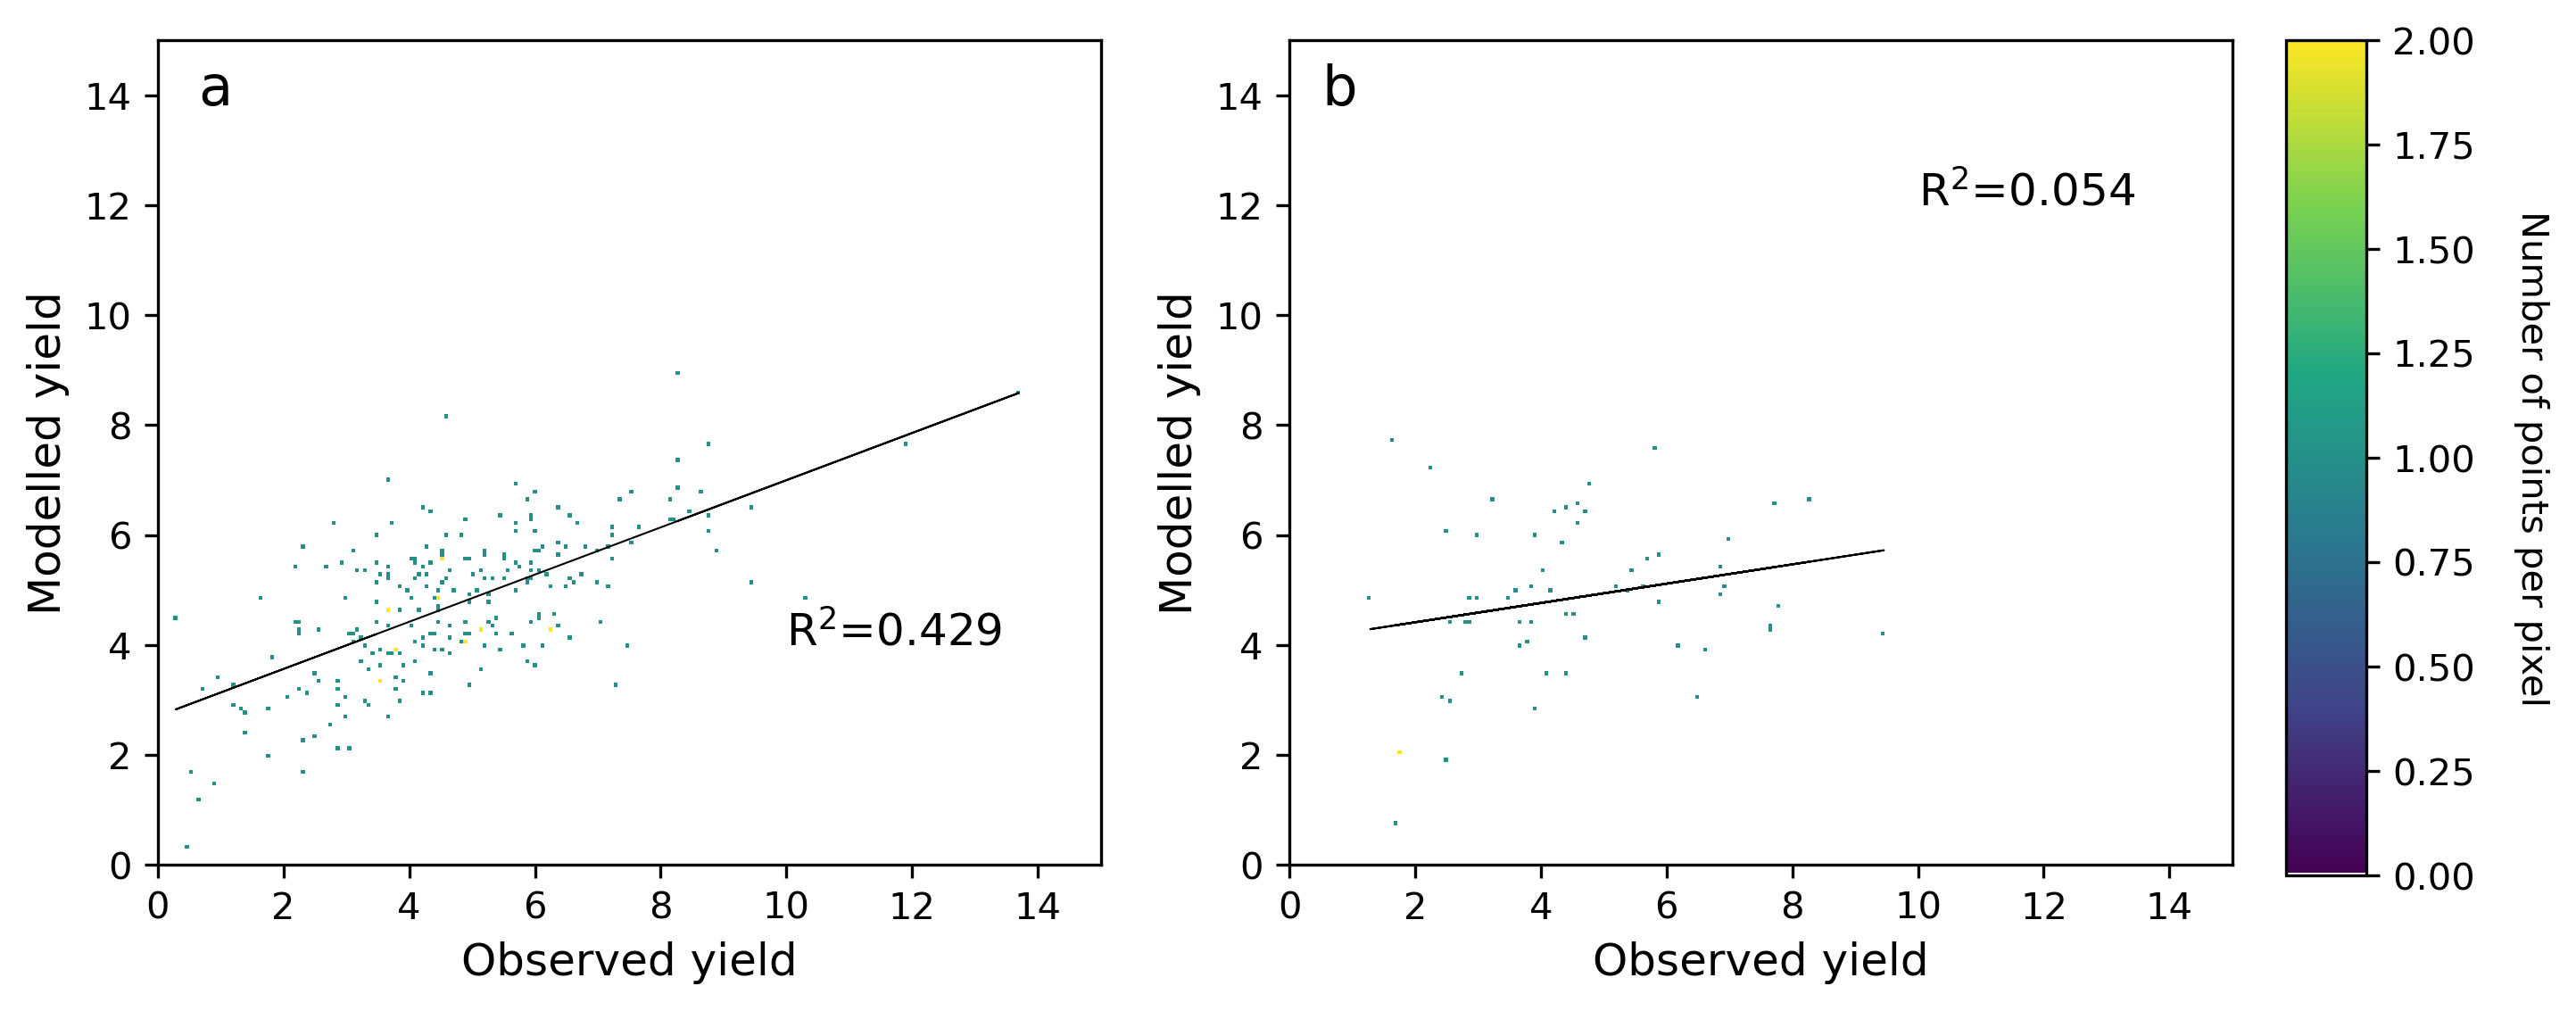

In [78]:
al=0
train=pd.DataFrame(columns=['obs','sim'])
test=pd.DataFrame(columns=['obs','sim'])
E=trial[['loc','yld']+cli].groupby('loc').mean().dropna().reset_index()
for c in cli: E[c+'_sqr']=E[c]**2
y=E['yld']
X=E[cli_all]  #cli_all
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=31)
lasso=Lasso(alpha=al,max_iter=1000000)
lasso.fit(X_train[cli_all],y_train) 
#rf=RandomForestRegressor(n_estimators=1000,random_state=42) #alpha=0.1,max_iter=10e6
#rf.fit(X_train[cli],y_train)
temp=pd.DataFrame(columns=['obs','sim'])
temp.obs=y_train
temp.sim=lasso.predict(X_train[cli_all])
#temp.sim=rf.predict(X_train[cli])

train=pd.concat([train,temp],ignore_index=True)

temp=pd.DataFrame(columns=['obs','sim'])
temp.obs=y_test
temp.sim=lasso.predict(X_test[cli_all])
#Yld_test=Yld_test.append(temp)
#temp.sim=rf.predict(X_test[cli])
test=pd.concat([test,temp],ignore_index=True)
fig=plt.figure(figsize=(10,4),dpi=300)
#Train
ax = fig.add_subplot(1,2,1,projection='scatter_density')
x=train.obs
y=train.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
density=ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(10,4,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
#Test
ax = plt.subplot(1,2,2,projection='scatter_density')
x=test.obs
y=test.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(10,12,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
cax=fig.add_axes([0.92,0.1,0.03,0.78])
cb=fig.colorbar(density,cax=cax)

cb.set_label('Number of points per pixel',rotation=270,labelpad=20)
plt.gcf().text(0.14,0.82,'a',fontsize=15)
plt.gcf().text(0.56,0.82,'b',fontsize=15)
plt.show()

In [84]:
trial=pd.read_csv(outdir+nursery[n]+"_Obs_Sim_Yld_Phe_Climate.csv")
Ej=trial[['loc','year','yld']].groupby(['loc','year']).mean().dropna().reset_index()
Ej=Ej.groupby('loc').count().reset_index()

# Loess regression - quardric 32

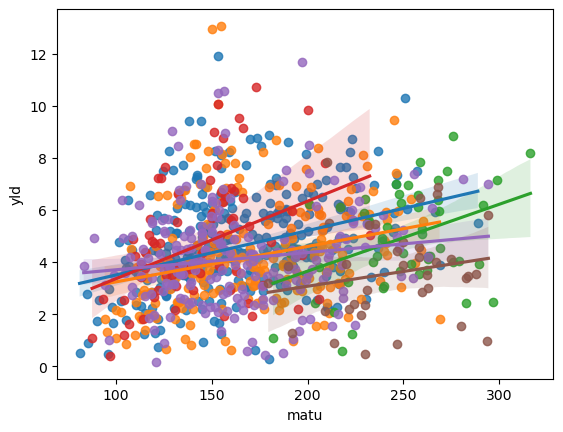

In [6]:

train1=pd.DataFrame(columns=['obs','sim'])
test1=pd.DataFrame(columns=['obs','sim'])
al=1
for n in range(6):
    trial=pd.read_csv(simphedir+nursery[n]+"\\Final_SimFilledSow__"+nursery[n]+".csv")
    trial['id']=trial.index
    trial['gen']=[x.split('@')[1] for x in trial.sid_gen]
    trial=trial[['id','gen','loc','wea_file','year','yearofsow','dayofsow','dayofhar','yld','head','anth','matu','sim_head','sim_anth','sim_matu']]
    matu=trial[['loc','matu']].groupby('loc').mean().dropna().reset_index()
    
    trial=pd.read_csv(outdir+nursery[n]+"_Obs_Sim_Yld_Phe_Climate.csv")
    Ej=trial[['loc','yld']].groupby('loc').mean().dropna().reset_index()
    Ej=Ej.merge(matu,on='loc',how='left')
    p=sns.regplot(x='matu',y='yld',data=Ej,robust=True)
    Ej_matu_reg=linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    #y=Ej_matu_reg[1]+Ej_matu_reg[0]x
    E_fit=Ej_matu_reg[1]+Ej_matu_reg[0]*Ej['matu']
    Ej['Ej']=Ej['yld']-E_fit-E_fit.mean()  #Ej is the site caused variation can not be explained by climate
    
    trial.drop('Ej', inplace=True, axis=1)
    trial=trial.merge(Ej[['loc','Ej']],on='loc',how='left')
    grand_mean=trial.yld.mean()
    trial['delYld1']=trial['yld']-grand_mean-trial['Gi']-trial['Ej']
    
    cli=[x+'_'+y for y in ['veg','rep','gfi'] for x in ['tavg','tdr','gdd30','rs','p','rh','vpd','ws']]
    cli_all=sum([[x+'_sqr',x] for x in cli],[])#+['co2']
    
    for g in trial.gen.unique():
        Yld=trial[trial.gen==g].iloc[:,3:][['delYld1','yld','Gi','Ej']+cli+['co2']].dropna()
        if Yld.shape[0]>=30: #make sure there are at least 10 sites
            #for c in cli: Yld[c+'_sqr']=Yld[c]**2
            y=Yld['delYld1']
            X=Yld[['yld','Gi','Ej']+cli]  #cli_all
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=31)
            lasso=Lasso(alpha=al,max_iter=1000000)
            lasso.fit(X_train[cli],y_train) 
            temp=pd.DataFrame(columns=['obs','sim'])
            temp.obs=X_train.yld
            temp.sim=lasso.predict(X_train[cli])+X_train.Gi+X_train.Ej+grand_mean
            #Yld_train=Yld_train.append(temp)
            train1=pd.concat([train1,temp],ignore_index=True)
            temp=pd.DataFrame(columns=['obs','sim'])
            temp.obs=X_test.yld
            temp.sim=lasso.predict(X_test[cli])+X_test.Gi+X_test.Ej+grand_mean
            #Yld_test=Yld_test.append(temp)
            test1=pd.concat([test1,temp],ignore_index=True)

D:\anaconda3\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
D:\anaconda3\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


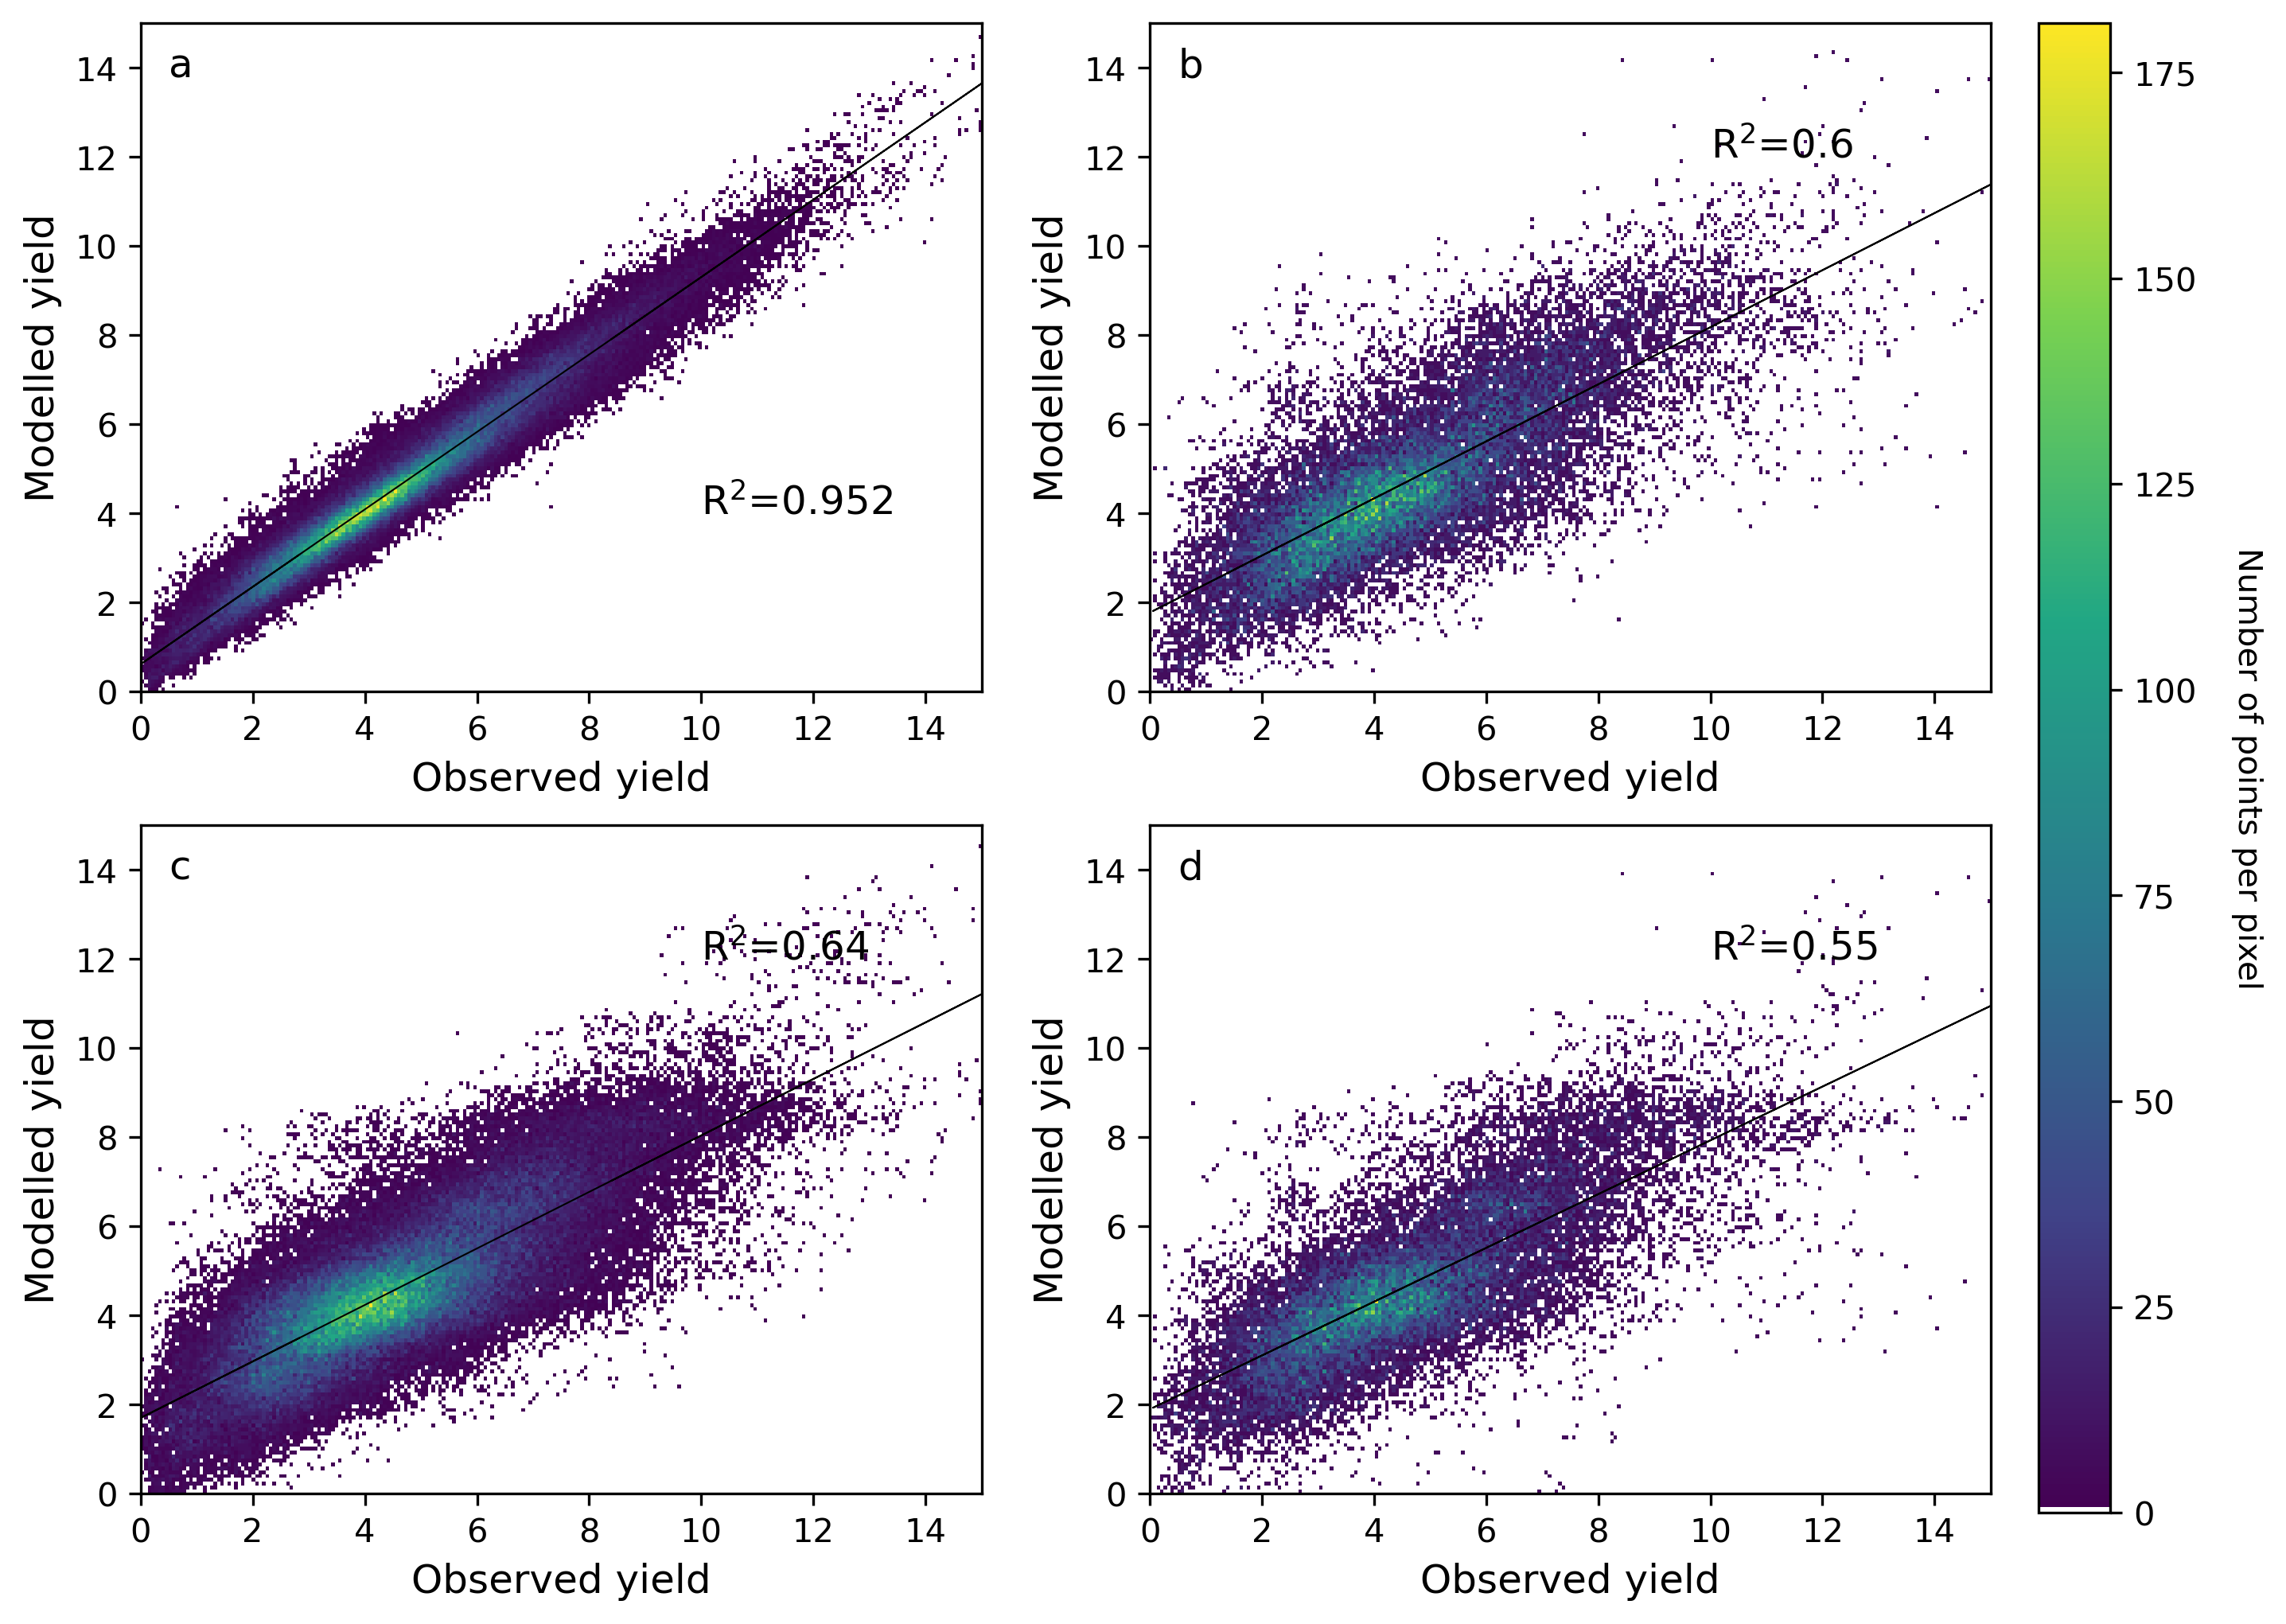

In [9]:
fig=plt.figure(figsize=(10,8),dpi=300)
#Train
ax = fig.add_subplot(2,2,1,projection='scatter_density')
x=train.obs
y=train.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
density=ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(10,4,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
ax.text(0.5,13.8,'a',fontsize=12)
#Test
ax = plt.subplot(2,2,2,projection='scatter_density')
x=test.obs
y=test.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(10,12,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
ax.text(0.5,13.8,'b',fontsize=12)
#Training LASSO
ax = plt.subplot(2,2,3,projection='scatter_density')
x=train1.obs
y=train1.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(10,12,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
ax.text(0.5,13.8,'c',fontsize=12)
#LASSO TEST
ax = plt.subplot(2,2,4,projection='scatter_density')
x=test1.obs
y=test1.sim
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b,'k-',linewidth=0.5)
ax.scatter_density(x,y,cmap=white_viridis)
r2=round(np.corrcoef(x,y)[0,1]**2,3)
ax.text(10,12,'R$^2$='+str(r2),fontsize=12)
ax.set_xlabel('Observed yield',fontsize=12)
ax.set_ylabel('Modelled yield',fontsize=12)
ax.set_xlim([0,15])
ax.set_ylim([0,15])
ax.text(0.5,13.8,'d',fontsize=12)

cax=fig.add_axes([0.92,0.1,0.03,0.78])
cb=fig.colorbar(density,cax=cax)
cb.set_label('Number of points per pixel',rotation=270,labelpad=20)
#plt.gcf().text(0.14,0.82,'A',fontsize=15)
#plt.gcf().text(0.56,0.82,'B',fontsize=15)
#plt.show()
fig.savefig(figdir+'Plot_S10_fittingApproach_4N.png',dpi=300,bbox_inches="tight")

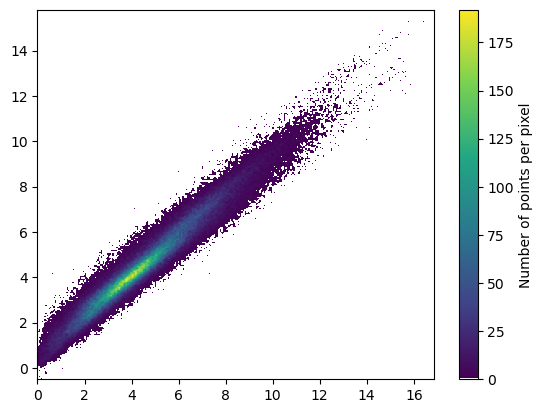

In [15]:

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

fig = plt.figure()
x=train.obs
y=train.sim
using_mpl_scatter_density(fig, x, y)
plt.show()

In [4]:
#WA and SE method and how to estimate
from scipy.interpolate import make_interp_spline

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28048\3869198272.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot2grid((5, 5), (1, 0), rowspan=4, colspan=4)


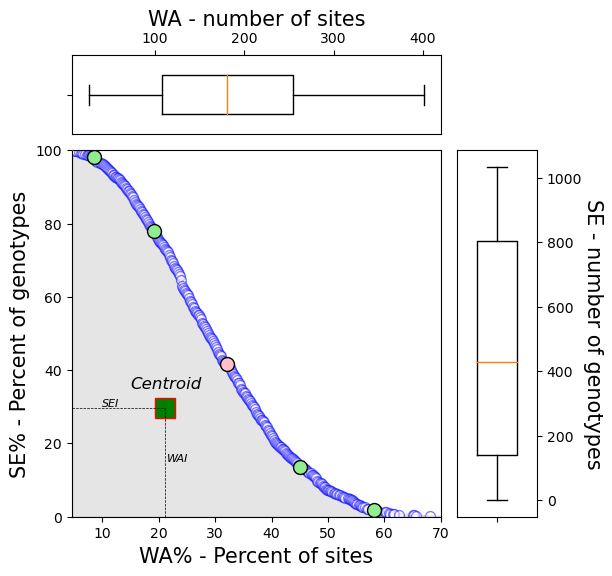

In [6]:
data_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\0_Adaptation\\3_Results\AdaptedLinesAndSites\\"
fig= plt.subplots(figsize=(6,6))

ax=plt.subplot2grid((5, 5), (1, 0), rowspan=4, colspan=4)
warmingsce=[0.26,1,2,3,4,5,6]
df=pd.read_csv(data_dir+nursery[0]+"_woco2_Threshold.csv")
wide_adaptation=[]
selection=[]
palette = sns.color_palette("RdYlGn_r", 7)  #nursery_color[1] husl
t=0
df1=df.iloc[:df.shape[0],1:df.shape[1]].applymap(lambda x: 1 if x>warmingsce[t] else 0)  #give 1 when adapted
df1['nsite']=df1.sum(axis=1)
#df1.loc['mean']=df1.mean()
wa=sorted(set(df1.nsite.tolist())) #sort values
se=[df1.loc[:,'nsite'].apply(lambda x: 1 if x>=i else 0).sum() for i in wa]
df2=pd.DataFrame()
df2['wa']=wa
df2['se']=se
df2['wa%']=[100*t/(df.shape[1]-1) for t in wa]
df2['se%']=[100*t/(df.shape[0]) for t in se]
df2=df2[df2>0].dropna()
#fit line
x=np.array(df2['wa%'])
y=np.array(df2['se%'])
X_Y_Spline=make_interp_spline(x,y)
X_=np.linspace(x.min(),x.max(),10)
Y_=X_Y_Spline(X_)
ax.plot(X_,Y_,linewidth=0.5,color='pink',zorder=10,alpha=0.5)
plt.fill_between(
        x= X_, 
        y1= Y_, 
        color= "grey",
        alpha= 0.2)
#cross point
#ax[n//3,n%3].scatter(df2.site,df2.line,s=2,color=palette[t],marker='+',zorder=10,label=str(t)+"$^\circ$C")
ax.scatter(df2['wa%'],df2['se%'],s=50,edgecolor="blue",c='white',marker='o',alpha=0.5)
wai,sei=np.dot(x,(y/sum(y)).T),np.dot(y,(x/sum(x)).T)
ax.plot(wai, sei, marker="s", markersize=15, markeredgecolor="red", markerfacecolor="green")
ax.set_xlim([4.6,70])
ax.set_ylim([0,100])
#Add lines to specify WAI and SAI
ax.plot([4.6, wai], [sei, sei], 'k--',linewidth=0.5)  #SEI
ax.plot([wai,wai],[0,sei],'k--',linewidth=0.5) #WAI

ax.set_xlabel('WA% - Percent of sites',fontsize=15)
ax.set_ylabel('SE% - Percent of genotypes',fontsize=15)
ax.text(15,35,"Centroid",fontsize=12,style='italic')
ax.text(10,30,"SEI",fontsize=8,style='italic')
ax.text(21.5,15,"WAI",fontsize=8,style='italic')

wai=[np.quantile(x,0.05),np.quantile(x,0.25),np.quantile(x,0.75),np.quantile(x,0.95)]
sei=[np.quantile(y,0.95),np.quantile(y,0.75),np.quantile(y,0.25),np.quantile(y,0.05)]
ax.plot(wai, sei, marker="o", markersize=10, markeredgecolor="k", markerfacecolor="lightgreen",linewidth=0,zorder=11)
ax.plot(np.quantile(x,0.5), np.quantile(y,0.5), marker="o", markersize=10, markeredgecolor="k", markerfacecolor="pink",linewidth=0,zorder=11)
#ax1=ax.twinx()
#ax1=ax.twiny()
wa_axes = plt.subplot2grid((5, 5), (0, 0), colspan=4)
se_axes = plt.subplot2grid((5, 5), (1, 4), rowspan=4)

wa_axes.boxplot(df2.wa,vert=False,showfliers=None,widths=0.5)
wa_axes.xaxis.set_label_position('top')
wa_axes.xaxis.tick_top()
wa_axes.tick_params(axis='y', which='both', labelleft=False, labelright=False)
wa_axes.set_xlabel('WA - number of sites',fontsize=15)

se_axes.boxplot(df2.se,showfliers=None,widths=0.5)
se_axes.yaxis.set_label_position("right")
se_axes.yaxis.tick_right()
se_axes.tick_params(axis='x', which='both', labeltop=False, labelbottom=False)
se_axes.set_ylabel('SE - number of genotypes',fontsize=15,rotation=270,labelpad=15)

plt.savefig(figdir+'Plot_S_WAI_SEI_computation.png',dpi=300,bbox_inches="tight")